In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
# create long representation for file and cust
#march = pd.read_hdf('../march.h5', 'df')
#march = march.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#april = pd.read_hdf('../april.h5', 'df')
#april = april.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#may = pd.read_hdf('../may.h5', 'df')
#may = may.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#data = pd.concat([march,april,may],axis=0)

#data = data.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id']]
#data.head(3) # take unique (file,cust)

In [3]:
#data.to_hdf('long_rep_file_cust.h5','df')
data = pd.read_hdf('custgp0.h5', 'df')
#data = pd.read_hdf('custgp1.h5', 'df')
#data = pd.read_hdf('custgp2.h5', 'df')
#data = pd.read_hdf('custgp3.h5', 'df')
#data = pd.read_hdf('custgp4.h5', 'df')

data.head(3)

,file_id,customer_id
0,00008c73ee43c15b16c26b26398c1577,033e91e730e176cd2ac81dc48a8f5088
1,00008c73ee43c15b16c26b26398c1577,06bea9f9c1d72c4d3151efa6bcd5ba83
2,00008c73ee43c15b16c26b26398c1577,113597f904c023f44d1a01babb780f58


In [4]:
file_df = pd.read_csv('file_df.csv')
file_df = file_df[['file_id','first_day']]

data = pd.merge(data,file_df,on='file_id',how='left')

train = pd.read_csv('../training-set.csv',header=None)
test = pd.read_csv('../testing-set.csv',header=None)

train.columns = ['file_id','target']
test.columns = ['file_id','target']

# full mean code
fullmeancode = pd.read_csv('final/forfullmeancode.csv')
train = pd.concat([train,fullmeancode],axis=0)
# full mean code


data = pd.merge(data,train,how='left',on='file_id')
data.head(3)

,file_id,customer_id,first_day,target
0,00008c73ee43c15b16c26b26398c1577,033e91e730e176cd2ac81dc48a8f5088,76,NaN
1,00008c73ee43c15b16c26b26398c1577,06bea9f9c1d72c4d3151efa6bcd5ba83,76,NaN
2,00008c73ee43c15b16c26b26398c1577,113597f904c023f44d1a01babb780f58,76,NaN


In [5]:
train.shape

(53033, 2)

In [6]:
data = data.sort_values(by=['first_day','file_id']).reset_index(drop=True)
data.head(3)

,file_id,customer_id,first_day,target
0,0087304d5bee451f0d82c7407b0fa7d1,662a1f7c7441bace48defd0f1947bc36,1,0.0
1,0087304d5bee451f0d82c7407b0fa7d1,71a15fcfe2741879c0d3a4588c011dae,1,0.0
2,0087e85caf760ff171b1774bafcafcae,00756aef13639abb552bbda410db6aff,1,0.0


In [7]:
tr_data = data[data['first_day']<50] # 62 for predict, 50 for val
tr_data = tr_data[['file_id','customer_id','target']]
tr_data.head(3)

,file_id,customer_id,target
0,0087304d5bee451f0d82c7407b0fa7d1,662a1f7c7441bace48defd0f1947bc36,0.0
1,0087304d5bee451f0d82c7407b0fa7d1,71a15fcfe2741879c0d3a4588c011dae,0.0
2,0087e85caf760ff171b1774bafcafcae,00756aef13639abb552bbda410db6aff,0.0


In [8]:
cumsum = tr_data.groupby(['customer_id']).cumsum().target - tr_data['target']
cumcnt = tr_data.groupby(['customer_id']).cumcount()
tr_data['mean_score'] = cumsum / cumcnt

# smoothing

In [9]:
tr_data['mean_score'].mean()

0.0064495294932422394

In [10]:
alpha = 20
gbmean = 0.007788156283522612
tr_data['mean_score'] = ((tr_data['mean_score'] * cumcnt)+(gbmean * alpha))/(cumcnt+alpha)

In [11]:
customer_score = tr_data.groupby(['customer_id']).last().reset_index()[['customer_id','mean_score']]
customer_df = pd.read_csv('rs_customer_df.csv')
customer_df = pd.merge(customer_df,customer_score,how='left',on='customer_id')


In [12]:
customer_df = customer_df[['customer_id','mean_score']]
customer_df.head(3)

,customer_id,mean_score
0,0000006fa286976bf35ea17f1f19bc7a,NaN
1,00000145d9062eada528bace5fb4864e,NaN
2,000003d77bee692d83b7b83fdba60d3d,NaN


In [13]:
customer_df['mean_score'].mean()

0.007437046950343279

In [14]:
##customer_df.loc[pd.isnull(customer_df).mean_score,'mean_score']=0.012656403967587571
customer_df = customer_df[customer_df['mean_score']>-1]
customer_df.shape

(1055175, 2)

In [15]:
customer_score = customer_score[customer_score['mean_score']>-1]

In [16]:
te_data = data[data['first_day']>49] # 61 for predict, 49 for val
te_data.head(3)

,file_id,customer_id,first_day,target
12121675,0021c7f072ad0e8068ab8c611700bfe1,04a890cd36f3cface3faeea2fc06967b,50,0.0
12121676,0021c7f072ad0e8068ab8c611700bfe1,052c7bc0c271b8f1accb80ca2bda46db,50,0.0
12121677,0021c7f072ad0e8068ab8c611700bfe1,07d2eef90ff6fdcc92092f81a0292d54,50,0.0


In [17]:
te_data = te_data.sort_values(by=['first_day','file_id']).reset_index(drop=True)
te_data = te_data[['file_id','customer_id']]
te_data = pd.merge(te_data,customer_score,how='left',on=['customer_id'] )
te_data.head(3)

,file_id,customer_id,mean_score
0,0021c7f072ad0e8068ab8c611700bfe1,04a890cd36f3cface3faeea2fc06967b,0.005371
1,0021c7f072ad0e8068ab8c611700bfe1,052c7bc0c271b8f1accb80ca2bda46db,0.005991
2,0021c7f072ad0e8068ab8c611700bfe1,07d2eef90ff6fdcc92092f81a0292d54,NaN


In [18]:
data = pd.concat([tr_data,te_data],ignore_index=True)
data.head(3)

,customer_id,file_id,mean_score,target
0,662a1f7c7441bace48defd0f1947bc36,0087304d5bee451f0d82c7407b0fa7d1,NaN,0.0
1,71a15fcfe2741879c0d3a4588c011dae,0087304d5bee451f0d82c7407b0fa7d1,NaN,0.0
2,00756aef13639abb552bbda410db6aff,0087e85caf760ff171b1774bafcafcae,NaN,0.0


In [19]:
data = data[data['mean_score']>-1]

In [20]:
data = data[['file_id','mean_score']]
exp_menc_cust = data.groupby('file_id').mean().reset_index()
exp_menc_cust.columns = ['file_id','cust_mean']

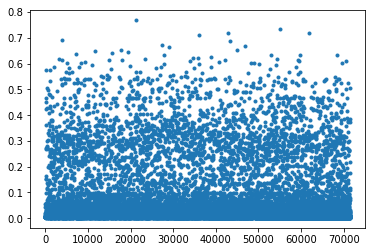

In [21]:
plt.plot(exp_menc_cust.cust_mean,'.')

In [22]:
train = pd.read_csv('../training-set.csv',header=None)
test = pd.read_csv('../testing-set.csv',header=None)
train.columns = ['file_id','target']
test.columns = ['file_id','target']
trte = pd.concat([train,test],axis=0)
trte = pd.merge(trte,exp_menc_cust,how='left',on='file_id')
trte = trte[['file_id','cust_mean']]
trte.head(3)

,file_id,cust_mean
0,0000e2398b12121a85166fed5fe2a3da,NaN
1,0001fe8dce14ce099aa6ca8ea5026ea7,0.006406
2,00027f50019000accc492e5684efc818,0.006727


In [23]:
trte.cust_mean.mean()

0.020254755145884564

In [24]:
trte.loc[pd.isnull(trte)['cust_mean'],'cust_mean']=0.021799171292379006
#0.021799171292379006 for gp0 re use
#0.039921794681213485 for gp1 re use
#0.0290912169302414 for gp2 re use
#0.0031946499630461896 for gp3 re use
#0.13124271573596175 for gp4 re use

In [25]:
trte.columns = ['file_id','cust_gp0_mean']
trte.head(3)

,file_id,cust_gp0_mean
0,0000e2398b12121a85166fed5fe2a3da,0.021799
1,0001fe8dce14ce099aa6ca8ea5026ea7,0.006406
2,00027f50019000accc492e5684efc818,0.006727


In [26]:
trte.to_csv('cust_gp0_val.csv',index=False)

In [27]:
# merge feature
custgp0 = pd.read_csv('cust_gp0_val.csv')
custgp1 = pd.read_csv('cust_gp1_val.csv')
custgp2 = pd.read_csv('cust_gp2_val.csv')
custgp3 = pd.read_csv('cust_gp3_val.csv')
custgp4 = pd.read_csv('cust_gp4_val.csv')

In [31]:
# merge feature
custgp0 = pd.read_csv('cust_gp0.csv')
custgp1 = pd.read_csv('cust_gp1.csv')
custgp2 = pd.read_csv('cust_gp2.csv')
custgp3 = pd.read_csv('cust_gp3.csv')
custgp4 = pd.read_csv('cust_gp4.csv')

In [32]:
custgp0.shape,custgp1.shape, custgp2.shape, custgp3.shape, custgp4.shape

((81894, 2), (81894, 2), (81894, 2), (81894, 2), (81894, 2))

In [33]:
cust = pd.merge(custgp1,custgp2,how='left',on='file_id')
cust = pd.merge(cust,custgp3,how='left',on='file_id')
cust = pd.merge(cust,custgp4,how='left',on='file_id')
cust = pd.merge(cust,custgp0,how='left',on='file_id')
cust.head(3)

,file_id,cust_gp1_mean,cust_gp2_mean,cust_gp3_mean,cust_gp4_mean,cust_gp0_mean
0,0000e2398b12121a85166fed5fe2a3da,0.039922,0.029091,0.003195,0.131243,0.021799
1,0001fe8dce14ce099aa6ca8ea5026ea7,0.000000,0.000000,0.000000,0.131243,0.006406
2,00027f50019000accc492e5684efc818,0.039922,0.029091,0.003195,0.157770,0.006727


In [30]:
cust.to_csv('cust_gpmean_val.csv',index=False)

In [34]:
cust.to_csv('cust_gpmean.csv',index=False)